# Stochastic Discrete Model
## Utility Matrix Calculation and Usage

In [12]:
import copy
from typing import List

import numpy as np
import sys
import seaborn as sb
import random as random
import networkx as nx
import matplotlib.pyplot as plt
from utils.point import Point
from environment.robots.basic_robot import BasicRobot
from environment.agents.fixed_velocity_agent import FixedVelocityAgent

In [13]:
def show_grid(M):
    min_val = np.min(M)
    max_val = np.max(M)
    sum_val = np.sum(M)

    M = np.flipud(M)
    fig, ax = plt.subplots(figsize=(20,6))
    sb.heatmap(M, annot=True, fmt=".2f", cmap='Blues', vmin=np.min(M), vmax=np.max(M), cbar_kws={"shrink": .8})
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    print(f'sum of mat cells: {sum_val}')
    print(f'max value is: {max_val}')
    print(f'min value is: {min_val}')

### initial state (lowest layer of the 3d position matrix PM)

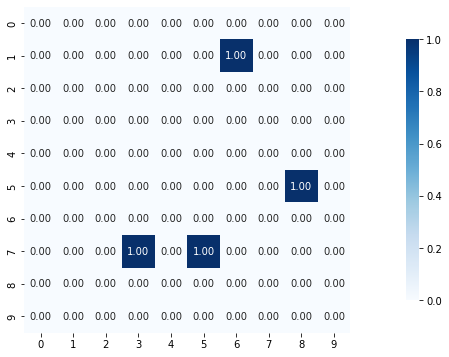

sum of mat cells: 4.0
max value is: 1.0
min value is: 0.0


In [14]:
b, br = 10, 10
probs = {'left': 0.2, 'up': 0.6, 'right':0.2}

agents = [FixedVelocityAgent(Point(3,2),1),
          FixedVelocityAgent(Point(5,2),1),
          FixedVelocityAgent(Point(6,8),1),
          FixedVelocityAgent(Point(8,4),1)]

robots = [BasicRobot(Point(1,1),2,1),
          BasicRobot(Point(2,0),2,1),
          BasicRobot(Point(4,1),2,1)]

n = len(agents)
k = len(robots)

max_damage = [b for agent in agents]

PM0 = np.zeros((b,br))
for agent in agents:
    c,r = agent.xy
    PM0[r][c] = 1

show_grid(PM0)

### calculating the position matrix PM

In [15]:
def advance(M):
    n_rows, n_cols = M.shape

    # next rows
    for r in range(n_rows-1,0,-1):
        # c = 0
        under = M[r-1][0]
        right = M[r-1][1]
        M[r][0] = under * (probs['left'] + probs['up']) + right * probs['right']

        # c = n_cols-1
        under = M[r-1][n_cols-1]
        left = M[r-1][n_cols-2]
        M[r][n_cols-1] = under * (probs['right'] + probs['up']) + left * probs['left']

        for c in range(1,n_cols-1):
            left = M[r-1][c-1]
            under = M[r-1][c]
            right = M[r-1][c+1]
            M[r][c] = probs['left'] * left + probs['up'] * under + probs['right'] * right

    # first row
    for c in range(n_cols):
        M[0][c] = 0

    return M

In [16]:
# maximal time
T = b - min([a.y for a in agents])
T

8

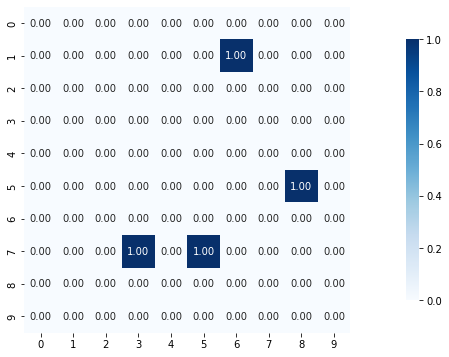

sum of mat cells: 4.0
max value is: 1.0
min value is: 0.0


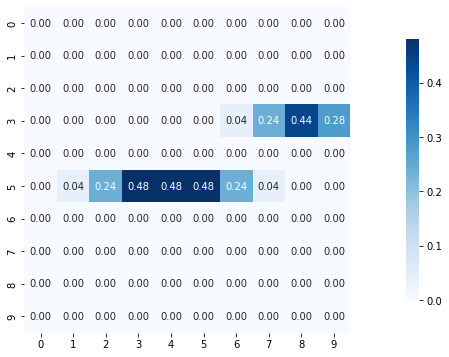

sum of mat cells: 3.0
max value is: 0.48000000000000004
min value is: 0.0


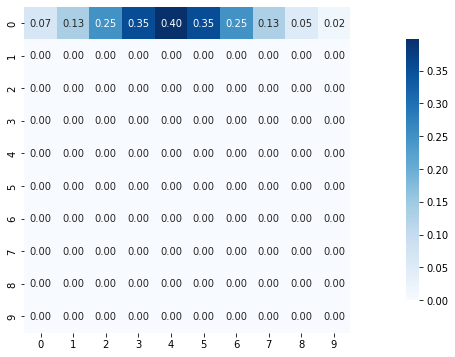

sum of mat cells: 2.0
max value is: 0.3976448
min value is: 0.0


In [17]:
# PM represents the expected amount of agents for each time and position
PM = np.zeros((T,b,br))
PMt = np.copy(PM0)
PM[0] = PMt

for t in range(1,T):
    PMt = advance(PMt)
    PM[t] = PMt

show_grid(PM[0])
show_grid(PM[2])
show_grid(PM[T-1])

### calculating the utility matrix UM

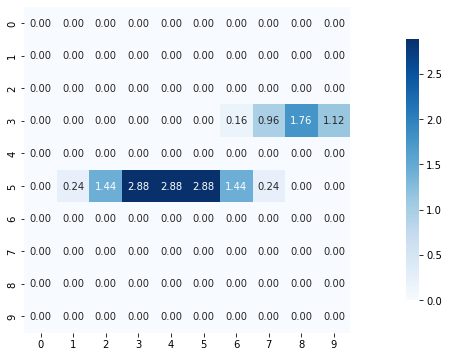

sum of mat cells: 16.0
max value is: 2.8800000000000003
min value is: 0.0


In [23]:
UM = np.zeros(PM.shape)
T,n_rows,n_cols = PM.shape
for t in range(T):
    for r in range(n_rows):
        for c in range(n_cols):
            # the utility is the prevented damage for this cell multiplied by the expected agents amount
            UM[t,r,c] = (b - r) * PM[t,r,c]

show_grid(UM[2])

### reducing the resolution into robots' resolution (robot cell is 4 agent cell)

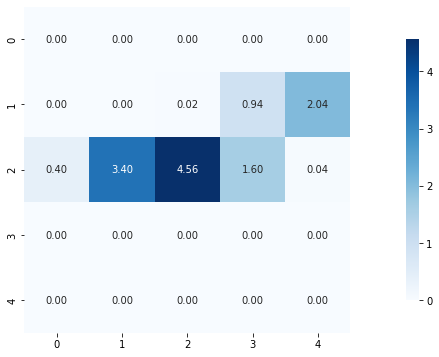

sum of mat cells: 13.0
max value is: 4.5600000000000005
min value is: 0.0


In [24]:
T,n_rows,n_cols = UM.shape
RUM = np.zeros((T,int(n_rows/2),int(n_cols/2)))

for t in range(T):
    for r in range(int(n_rows/2)):
        for c in range(int(n_cols/2)):
            RUM[t][r][c] = UM[t][2*r][2*c] + UM[t][2*r+1][2*c] + UM[t][2*r][2*c+1] + UM[t][2*r+1][2*c+1]

show_grid(RUM[3])

## StaticLineLack
### reachability graph on one row

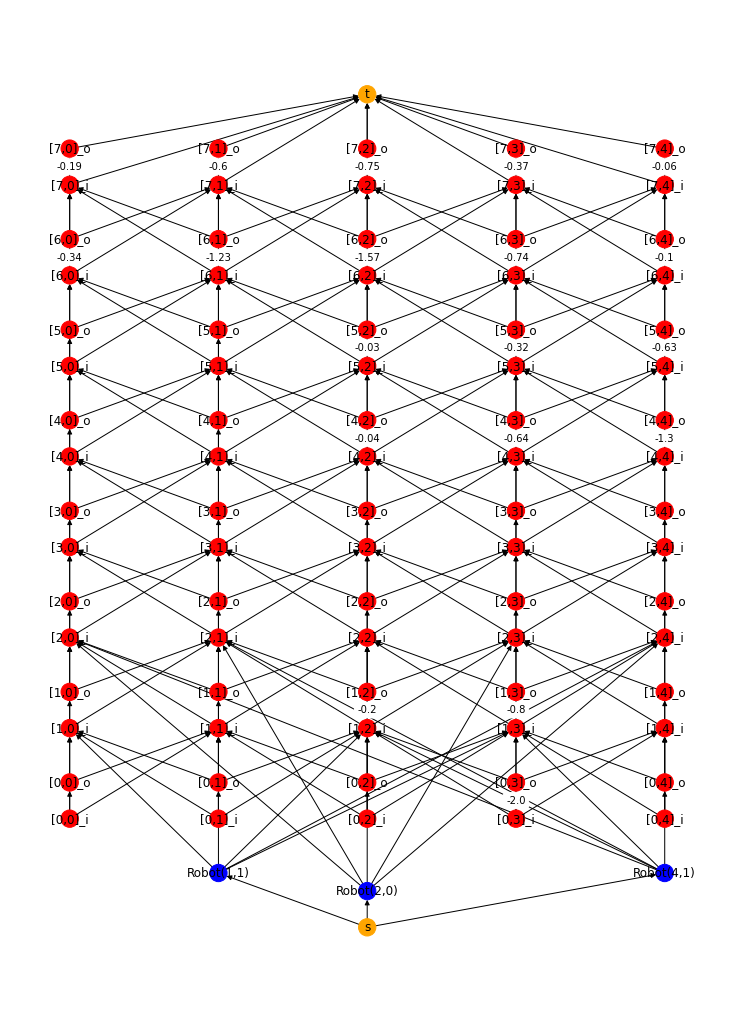

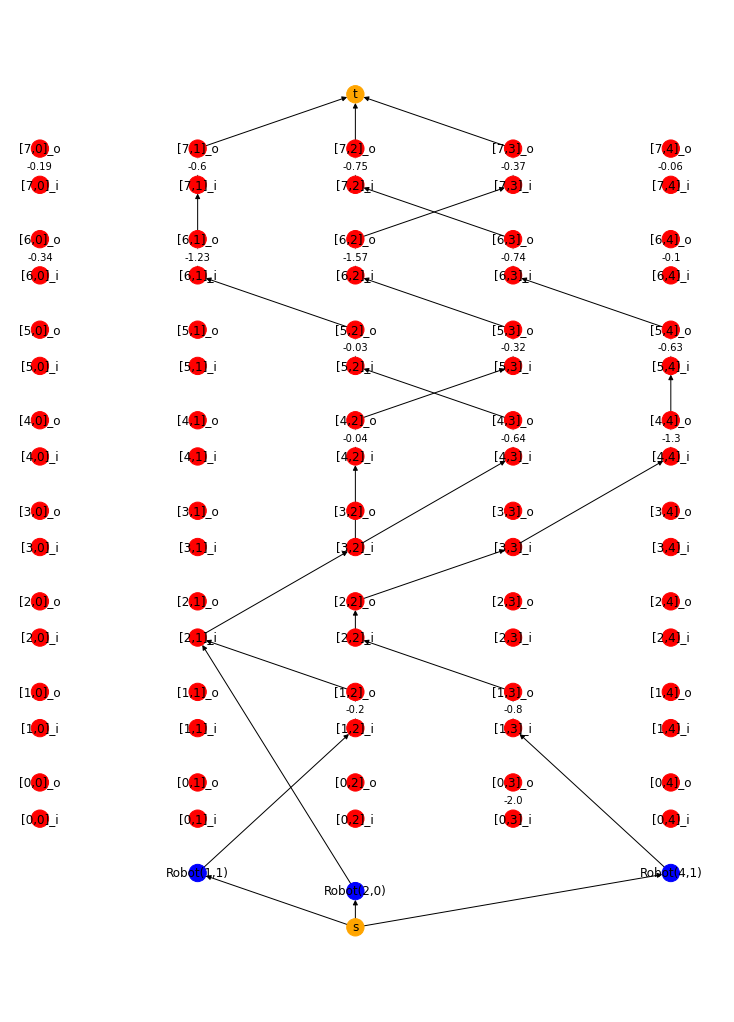

expected damage avoided is 9.22


In [20]:
def flow_moves(robots: List['BasicRobot'], row: float, RUM, draw=False):
    RUR = RUM[:,row,:]
    T, n_cols = RUR.shape

    g = nx.DiGraph()

    # create robots
    for robot in robots:
        g.add_node(str(robot), pos=np.array([robot.x, robot.y]), color='blue')

    # create utility cells
    for t in range(T):
        for c in range(n_cols):
            g.add_node(f'[{t},{c}]_i', pos=np.array([c, 4 + 5 * t]), color='red')
            g.add_node(f'[{t},{c}]_o', pos=np.array([c, 4 + 5 * t + 2]), color='red')
            # the weight needs to be an integer
            g.add_edge(f'[{t},{c}]_i', f'[{t},{c}]_o', weight=-int(100*RUR[t,c]), capacity=1)

    # add edges between cells
    for t in range(T-1):
        g.add_edge(f'[{t},{0}]_o',f'[{t+1},{0}]_i', weight=0, capacity=len(robots))
        g.add_edge(f'[{t},{0}]_o',f'[{t+1},{1}]_i', weight=0, capacity=len(robots))

        g.add_edge(f'[{t},{0}]_i',f'[{t+1},{0}]_i', weight=0, capacity=len(robots))
        g.add_edge(f'[{t},{0}]_i',f'[{t+1},{1}]_i', weight=0, capacity=len(robots))

        g.add_edge(f'[{t},{n_cols-1}]_o',f'[{t+1},{n_cols-1}]_i', weight=0, capacity=len(robots))
        g.add_edge(f'[{t},{n_cols-1}]_o',f'[{t+1},{n_cols-2}]_i', weight=0, capacity=len(robots))

        g.add_edge(f'[{t},{n_cols-1}]_i',f'[{t+1},{n_cols-1}]_i', weight=0, capacity=len(robots))
        g.add_edge(f'[{t},{n_cols-1}]_i',f'[{t+1},{n_cols-2}]_i', weight=0, capacity=len(robots))

        for c in range(1,n_cols-1):
            g.add_edge(f'[{t},{c}]_o',f'[{t+1},{c-1}]_i', weight=0, capacity=len(robots))
            g.add_edge(f'[{t},{c}]_o',f'[{t+1},{c}]_i', weight=0, capacity=len(robots))
            g.add_edge(f'[{t},{c}]_o',f'[{t+1},{c+1}]_i', weight=0, capacity=len(robots))

            g.add_edge(f'[{t},{c}]_i',f'[{t+1},{c-1}]_i', weight=0, capacity=len(robots))
            g.add_edge(f'[{t},{c}]_i',f'[{t+1},{c}]_i', weight=0, capacity=len(robots))
            g.add_edge(f'[{t},{c}]_i',f'[{t+1},{c+1}]_i', weight=0, capacity=len(robots))

    # for each column and robot, add edge corresponding to the arrival time
    for robot in robots:
        for c in range(n_cols):
            arrival_time = int(Point(c, row).distance_to(robot.loc) / robot.fv)
            g.add_edge(str(robot),f'[{arrival_time},{c}]_i', weight=0, capacity=1)

    # add dummy source and target to use flow
    g.add_node('s', pos=np.array([2, -2]), color='orange')
    g.add_node('t', pos=np.array([2, 5 * T + 4]), color='orange')

    for robot in robots:
        g.add_edge('s', str(robot), weight=0, capacity=1)

    for c in range(n_cols):
        g.add_edge(f'[{T-1},{c}]_o','t', weight=0, capacity=len(robots))
        g.add_edge(f'[{T-1},{c}]_i','t', weight=0, capacity=len(robots))

    # plt.xlim([0, 20])
    # plt.ylim([0, 20])
    plt.figure(3,figsize=(10,14))
    edge_labels = {k: v/100 for k, v in nx.get_edge_attributes(g,'weight').items() if v != 0}
    pos = nx.get_node_attributes(g,'pos')

    if draw:
        nx.draw(g, pos=pos,
                node_color=nx.get_node_attributes(g,'color').values(),
                with_labels=True)
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, rotate=False)
        plt.show()

    flow = nx.max_flow_min_cost(g, 's', 't')

    # delete all edges without flow
    edges_to_delete = []
    for key1, val1 in flow.items():
        for key2, val2 in val1.items():
            if val2 == 0:
                edges_to_delete.append((key1, key2))
    for key1, key2 in edges_to_delete:
        g.remove_edge(key1, key2)

    if draw:
        plt.figure(3,figsize=(10,14))
        nx.draw(g, pos=pos,
                node_color=nx.get_node_attributes(g,'color').values(),
                with_labels=True)
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, rotate=False)
        plt.show()

    return -sum(nx.get_edge_attributes(g,'weight').values())/100

print(f'expected damage avoided is {flow_moves(robots, 4, RUM, draw=True)}')

In [21]:
T, n_rows, n_cols = RUM.shape
scores = {row : flow_moves(robots, row, RUM) for row in range(n_rows)}
row_opt = max(list(range(n_rows)), key=lambda row: scores[row])
print(row_opt)
print(scores)

2
{0: 0.0, 1: 30.0, 2: 32.32, 3: 19.87, 4: 9.22}


<Figure size 720x1008 with 0 Axes>